In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *

In [2]:
df = pd.read_json('data/dbdump_testdb.jobs_v5.json')
df = df[df['company'].str.contains('ecco')]
df['description'].unique().tolist()

['Adecco Italia Spa, filiale di San Giovanni in Persiceto, ricerca per azienda cliente di San Giovanni in Persiceto, un/a: ADDETTO/A CATERING Responsabilità: - Organizzare e gestire il servizio di catering per eventi e occasioni speciali; - Supervisionare il personale addetto alla preparazione e alla distribuzione dei pasti; - Garantire il rispetto delle norme igienico-sanitarie; - Assicurarsi che gli standard di qualità siano sempre mantenuti. Requisiti: - Esperienza pregressa nel ruolo; - Capacità di lavorare in team; - Conoscenza delle norme igienico-sanitarie; - Disponibilità a lavorare nei wee-end e a svolgere straordinari. Si offre contratto iniziale in somministrazione, scopo assunzione. Orario di lavoro: Full-time dal Lunedì al Venerdì con disponibilità nei week-end.\n\nCCNL: Turismo - pubblici servizi, retribuzione 1500E lordi Disponibilità oraria: Full Time Patente: B Mezzo di trasporto: Auto,',
 "Opportunità: Hai la passione per il settore bancario? Candidati! Ricerchiamo pe

In [31]:
df = pd.read_csv('data/job_description_seed_dataset_improved_context.csv')
df['len'] = df.apply(lambda x: len(x['text']), axis=1)
df.sort_values('len', ascending=False, inplace=True)
df[df['inclusive phrasing'] == 'NO'].head(100)['text'].iloc[14]

"La risorsa inserita si occuperà delle seguenti attività: Gestione e smistamento corrispondenza generale: mail, telefono, chat; Gestione sale riunioni: prenotazioni e cura dell’ordine delle sale; Gestione attività di segreteria generale: a supporto di colleghi e responsabili; Monitoraggio sistemi di sicurezza; Gestione trasferte e viaggi; Coordinamento eventi interni: riunioni interne, meeting, formazione, piccoli eventi interni; Attività varie a supporto dell'area Marketing."

phi3-finetuned
   count    %     df prompt_id           true
0  111.0  1.0    raw     zsl#0      INCLUSIVO
0  111.0  1.0  fixed     zsl#0      INCLUSIVO
0   39.0  1.0    raw     zsl#0  NON INCLUSIVO
0   39.0  1.0  fixed     zsl#0  NON INCLUSIVO


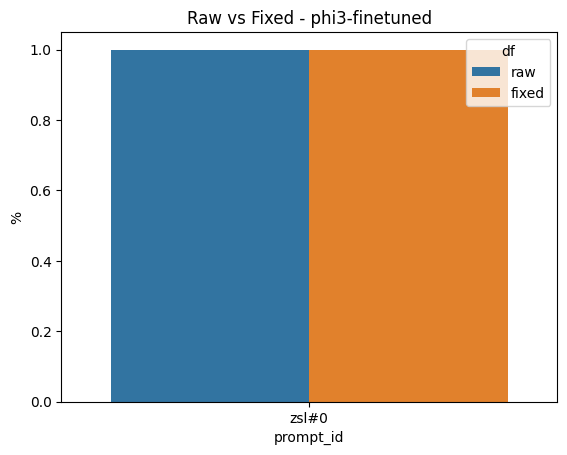

zsl#0


ZeroDivisionError: division by zero

In [4]:
res_models_df = None

show_plots = True

for model in ['phi3-finetuned']:
    print(model)
    if model == 'phi3-finetuned':
        df = pd.read_csv(f'results/{model}-eval.csv')
    # df = df[df['prompt_id'].str.contains('cot')]

    df_fix = fix_df(df, model, show_plot=show_plots)
    # df_fix

    # print(df_fix['true'].value_counts())
    # print(df_fix['response'].value_counts())

    for p in df_fix['prompt_id'].unique():
        print(p)

        _df = df_fix[df_fix['prompt_id'] == p]
        df_jobs = _df[_df['text_labels'] == 'TODO']
        df_notjobs = _df[_df['text_labels'] != 'TODO']
        
        # sns.countplot(data=df_jobs, x='true')
        # plt.show()

        all = metrics(_df)
        all['name'] = 'all'
        res_df = pd.DataFrame(all, index=[0])
        all['name'] = model + " - " + p
        if res_models_df is None:
            res_models_df = pd.DataFrame(all, index=[0])
        else:
            res_models_df = pd.concat([res_models_df, pd.DataFrame(all, index=[0])])


        _metrics = metrics(df_jobs)
        _metrics['name'] = 'jobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs)
        _metrics['name'] = 'notjobs'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(isin(df_jobs, NEUTRALS))
        # _metrics['name'] = 'neutrals'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # symbols = ['Ã',' e ',' o ','\*','/']
        # for s in symbols:
        #     _metrics = metrics(contains(df_jobs, [s]))
        #     _metrics['name'] = s
        #     res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'notjob_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_notjobs[df_notjobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'notjob_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'INCLUSIVO'])
        _metrics['name'] = 'job_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        _metrics = metrics(df_jobs[df_jobs['true'] == 'NON INCLUSIVO'])
        _metrics['name'] = 'job_not_inclusive'
        res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        if show_plots:
            print(res_df)
            plot_metrics(res_df, f" - {model} - {p}")

plot_metrics(res_models_df, "- All models")